In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

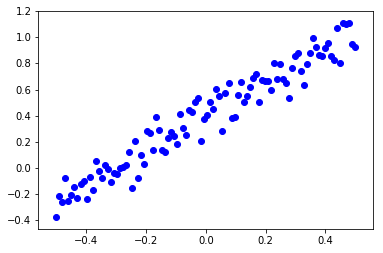

In [3]:
# first generate some observations
true_a = 1.3
true_b = 0.4
data_x = (np.arange(100) / 99.0 - .5).astype(np.float32)
data_y = (data_x * true_a + true_b + np.random.randn(*data_x.shape) * 0.1).astype(np.float32)
_ = plt.scatter(data_x, data_y, c='b')

In [4]:
model = nn.Linear(1,1)

In [5]:
model.weight

Parameter containing:
 0.5209
[torch.FloatTensor of size 1x1]

In [6]:
model.bias

Parameter containing:
-0.2180
[torch.FloatTensor of size 1]

In [7]:
var_result = model.weight + 123

In [8]:
var_result

Variable containing:
 123.5209
[torch.FloatTensor of size 1x1]

In [9]:
var_result.data


 123.5209
[torch.FloatTensor of size 1x1]

In [10]:
model.weight.data


 0.5209
[torch.FloatTensor of size 1x1]

In [11]:
model_y = model(Variable(torch.from_numpy(data_x[:, None]))) 

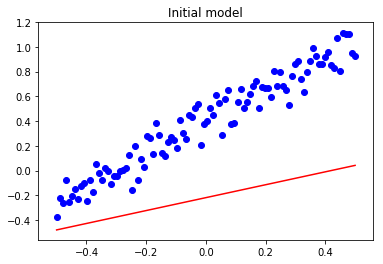

In [12]:
_ = plt.plot(data_x, model_y.data.numpy()[:,0], c='r')
_ = plt.scatter(data_x, data_y, c='b')
_ = plt.title("Initial model")

In [13]:
data_y_v = Variable(torch.from_numpy(data_y))
loss_criterion = nn.MSELoss()
loss = loss_criterion(model_y, data_y_v)

In [14]:
loss.backward()

In [16]:
print("dloss/dW : {}".format(model.weight.grad))

dloss/dW : Variable containing:
-0.1312
[torch.FloatTensor of size 1x1]



In [17]:
type(model(data_x_v))

NameError: name 'data_x_v' is not defined

Itr 0 loss: Variable containing:
 0.3035
[torch.FloatTensor of size 1]

Itr 25 loss: Variable containing:
 0.2685
[torch.FloatTensor of size 1]

Itr 50 loss: Variable containing:
 0.1829
[torch.FloatTensor of size 1]

Itr 75 loss: Variable containing:
1.00000e-02 *
  8.7521
[torch.FloatTensor of size 1]



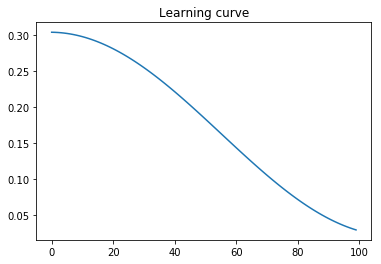

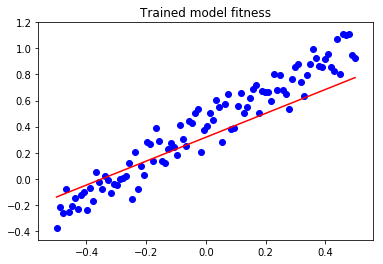

In [21]:
model = nn.Linear(1,1)
losses = []
data_x_v = Variable(torch.from_numpy(data_x[:,None]))
data_y_v = Variable(torch.from_numpy(data_y))
learning_rate = 0.0001

for i in range(100):
    loss = loss_criterion(model(data_x_v),data_y_v)
    losses.append(float(loss.data[0]))
    loss.backward()
    ## *** YOUR CODE HERE TO PERFORM GRADIENT DESCENT ***
    ## Hint: you could access gradients with model.W.grad, model.b.grad
    ## Hint2: you could write data into a parameter with model.W.data[:] = some_numpy_array
    ## Hint3: if your model doesn't learn, remember to try different learning rates
    model.weight.data.sub_(learning_rate * model.weight.grad.data)
    model.bias.data.sub_(learning_rate * model.bias.grad.data)
    if i % 25 == 0:
        print("Itr", i, "loss:", loss)
plt.plot(np.array(losses))
plt.title("Learning curve")
plt.figure()
plt.plot(data_x, model(data_x_v).data.numpy()[:,0], c='r')
plt.scatter(data_x, data_y, c='b')
_ = plt.title("Trained model fitness")

In [22]:
import torchvision.datasets as dset
import torchvision.transforms as transforms

root = '/Users/koustuv/data/'
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train = dset.MNIST(root=root, train=True, transform=trans, download=True)
test = dset.MNIST(root=root, train=False, transform=trans)

Reference : https://gist.github.com/xmfbit/b27cdbff68870418bdb8cefa86a2d558

In [23]:
print("train[i][0] is the ith image that's flattened, and has shape:", train[12][0].shape)
print("train[i][1] is the ith image's label, such as:", train[12][1])

train[i][0] is the ith image that's flattened, and has shape: torch.Size([1, 28, 28])
train[i][1] is the ith image's label, such as: 3


train and test are already FloatTensors

In [24]:
train[12][0].numpy().squeeze(0).shape

(28, 28)

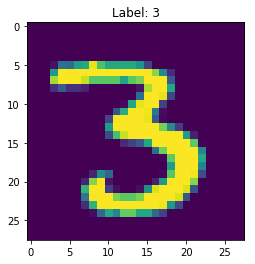

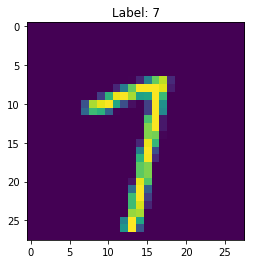

In [25]:
plt.imshow(train[12][0].numpy().squeeze(0))
plt.title("Label: %s" % train[12][1])
plt.figure()
plt.imshow(train[42][0].numpy().squeeze(0))
_ = plt.title("Label: %s" % train[42][1])

In [26]:
batch_size = 32
kwargs = {'num_workers': 1, 'pin_memory': False} # pin_memory True for CUDA
train_loader = torch.utils.data.DataLoader(
                 dataset=train,
                 batch_size=batch_size,
                 shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
                dataset=test,
                batch_size=batch_size,
                shuffle=False, **kwargs)

In [56]:
from collections import namedtuple, defaultdict, deque

In [78]:
def run(model, num_epochs=2):
    
    params = model.parameters()
    optimizer = optim.Adam(params)
    loss_criterion = nn.CrossEntropyLoss()
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        
        for batch_idx, (x, target) in enumerate(train_loader):
            optimizer.zero_grad()
            xs, ys = Variable(x), Variable(target)
            
            # modify the inputs so that we save the last layer as 28x28
            xs = xs.squeeze(1)
            xs = xs.view(xs.size(0),-1)
            

            logits = model(xs)

            loss = loss_criterion(logits, ys)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print '==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(epoch, batch_idx, loss.data[0])

        correct_cnt, ave_loss = 0, 0
        for batch_idx, (x, target) in enumerate(test_loader):
            x, ys = Variable(x, volatile=True), Variable(target, volatile=True)
            x = x.squeeze(1).view(x.size(0),-1)
            logits = model(x)
            loss = loss_criterion(logits, ys)
            _, pred_label = torch.max(logits.data, 1)
            correct_cnt += (pred_label == ys.data).sum()
            ave_loss += loss.data[0]
        accuracy = correct_cnt*1.0/len(test_loader)/batch_size
        ave_loss /= len(test_loader)
        print '==>>> epoch: {}, test loss: {:.6f}, accuracy: {:.4f}'.format(epoch, ave_loss, accuracy)

# try a simple linear model
run(nn.Linear(784,10))

==>>> epoch: 0, batch index: 0, train loss: 2.286474
==>>> epoch: 0, batch index: 100, train loss: 0.870153
==>>> epoch: 0, batch index: 200, train loss: 0.668066
==>>> epoch: 0, batch index: 300, train loss: 0.431853
==>>> epoch: 0, batch index: 400, train loss: 0.445432
==>>> epoch: 0, batch index: 500, train loss: 0.514513
==>>> epoch: 0, batch index: 600, train loss: 0.594494
==>>> epoch: 0, batch index: 700, train loss: 0.401016
==>>> epoch: 0, batch index: 800, train loss: 0.423016
==>>> epoch: 0, batch index: 900, train loss: 0.483836
==>>> epoch: 0, batch index: 1000, train loss: 0.479537
==>>> epoch: 0, batch index: 1100, train loss: 0.703239
==>>> epoch: 0, batch index: 1200, train loss: 0.289755
==>>> epoch: 0, batch index: 1300, train loss: 0.457936
==>>> epoch: 0, batch index: 1400, train loss: 0.228384
==>>> epoch: 0, batch index: 1500, train loss: 0.261497
==>>> epoch: 0, batch index: 1600, train loss: 0.335850
==>>> epoch: 0, batch index: 1700, train loss: 0.572073
==>>

In [ ]:
class MLP(nn.Module):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(n_in, n_units)  # n_in -> n_units
        self.l2 = nn.Linear(n_units, n_units)  # n_units -> n_units
        self.l3 = nn.Linear(n_units, n_out)  # n_units -> n_out

    def __call__(self, x):
        # *** YOUR CODE HERE TO BUILD AN MLP W/ self.l1, self.l2, self.l3 ***
        # 
        # Hint: you should make use of non-linearities / activation functions
        #     https://docs.chainer.org/en/stable/reference/functions.html#activation-functions
        raise NotImplementedError()
run(MLP(200, 10))